In [ ]:
## install dependencies
!pip3 --no-cache-dir install \
        numpy \
        torch==1.5.1 \
        torchvision==0.6.1 \
        foolbox==1.8.0 \

In [3]:
import sys
sys.path.insert(0, './../') 
%load_ext autoreload
# %autoreload 2
%matplotlib inline
%tensorflow_version 1.x
import torch
from torchvision import datasets, transforms

import time
import numpy as np
from matplotlib import pyplot as plt
import foolbox 
from foolbox import attacks as fa
import tensorflow as tf
tf.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# own modules
from abs_models import utils as u
from abs_models import models as mz
from abs_models import attack_utils as au


TensorFlow 1.x selected.


In [57]:
model = mz.get_VAE(n_iter=20, n_samples=1000)             # ABS, do n_iter=50 for original model 
# model = mz.get_VAE(binary=True)           # ABS with scaling and binaryzation
# model = mz.get_binary_CNN()               # Binary CNN
# model = mz.get_CNN()                      # Vanilla CNN
# model = mz.get_NearestNeighbor()          # Nearest Neighbor, "nearest L2 dist to each class"=logits
# model = mz.get_madry()                    # Robust network from Madry et al. in tf
def load_madry_model(model_path = '/content/drive/MyDrive/pgd_model_aaa'):
    import tensorflow as tf
    # model = tf.keras.models.load_model(model_path)
    model = pgd_model
    model.code_base = 'tensorflow'
    model.has_grad = True
    return model
# model = load_madry_model()

ABS model
model loaded


In [58]:
# code is agnostic of pytorch/ tensorflow model --> foolbox model
if model.code_base == 'tensorflow':
    fmodel = foolbox.models.TensorFlowModel(model.x_input, model.pre_softmax, (0., 1.),
                                            channel_axis=3)
elif model.code_base == 'pytorch':
    model.eval()
    fmodel = foolbox.models.PyTorchModel(model,   # return logits in shape (bs, n_classes)
                                         bounds=(0., 1.), num_classes=10,
                                         device=u.dev())
elif model.code_base == 'keras':
    tf.disable_eager_execution()
    fmodel = foolbox.models.KerasModel(model, (0., 1.),
                                            channel_axis=3)
else:
    print('not implemented')

In [59]:
# test model 
b, l = u.get_batch(bs=55000)  # returns random batch as np.array
pred_label = np.argmax(fmodel.batch_predictions(b), axis=1)
print('score', float(np.sum(pred_label == l)) / b.shape[0])

setting random seed
done creating samples
score 0.9708


In [ ]:
b, l = u.get_batch(bs=1000)  # returns random batch
start = time.time()
metric = foolbox.distances.MSE
criterion = foolbox.criteria.Misclassification()
att = fa.PointwiseAttack(fmodel)

# Estimate gradients from scores
if not model.has_grad: 
    GE = foolbox.gradient_estimators.CoordinateWiseGradientEstimator(0.1)
    fmodel = foolbox.models.ModelWithEstimatedGradients(fmodel, GE)

# generate Adversarial
adversarial_imgs = np.zeros_like(b)
for i in range(adversarial_imgs.shape[0]):
    a = foolbox.adversarial.Adversarial(fmodel, criterion, b[i],
                                        l[i], distance=metric)
    att(a)
    adversarial_imgs[i] = a.image
    print('\r', 'Adversarial images created:', i, end='')
    if i % 10 == 0:
        print("%s adversarial images created" % i)


print('runtime', time.time() - start, 'seconds')
pred_label = np.argmax(fmodel.batch_predictions(adversarial_imgs), axis=1)
print('score', float(np.sum(pred_label == l)) / b.shape[0])


In [62]:
!ls

attacks.ipynb  attacks.py


In [61]:
## model score
pred_label = np.argmax(fmodel.batch_predictions(adversarial_imgs[:45]), axis=1)
print('score', float(np.sum(pred_label == l)) / 45)

score 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


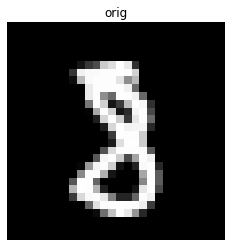

pred 8


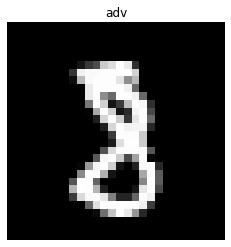

pred 2


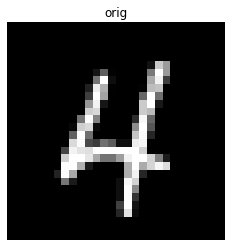

pred 4


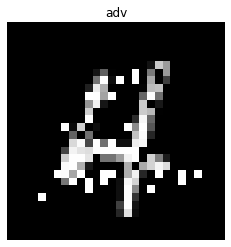

pred 2


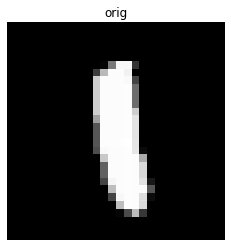

pred 1


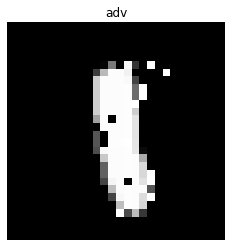

pred 8


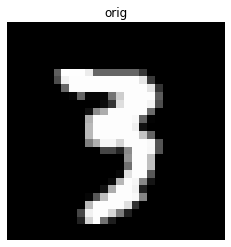

pred 3


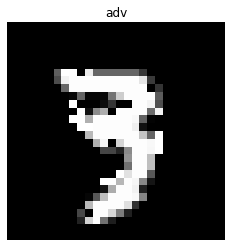

pred 9


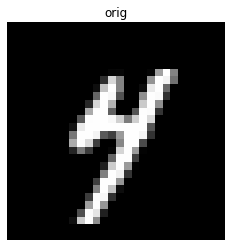

pred 4


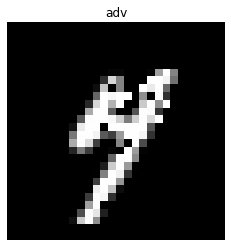

pred 9


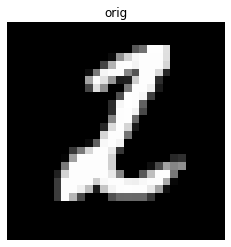

pred 2


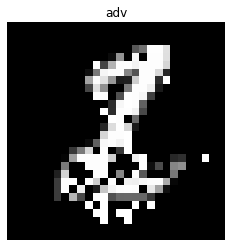

pred 8


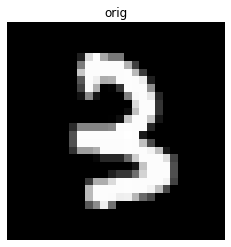

pred 3


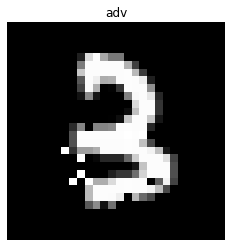

pred 2


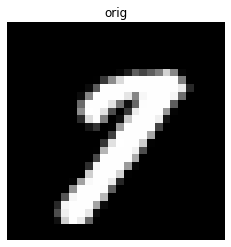

pred 7


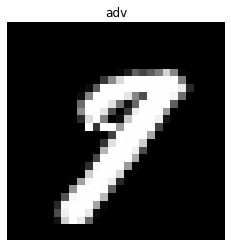

pred 9


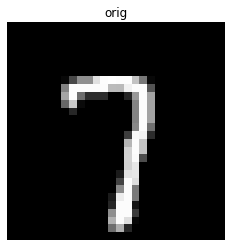

pred 7


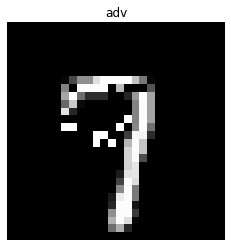

pred 9


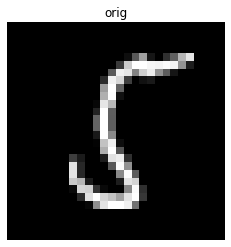

pred 5


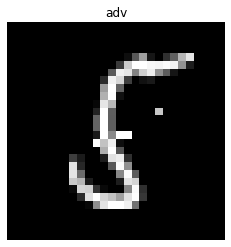

pred 8


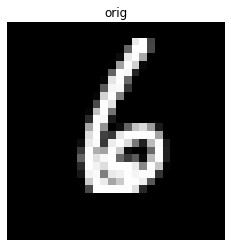

pred 6


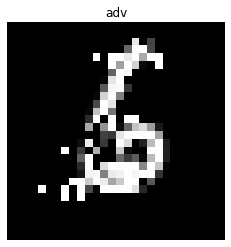

pred 5


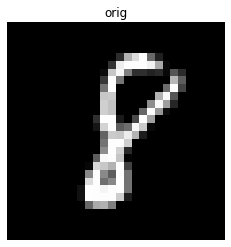

pred 8


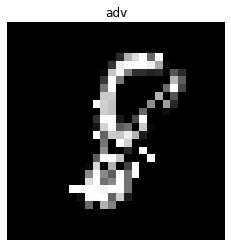

pred 5


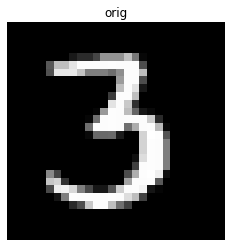

pred 3


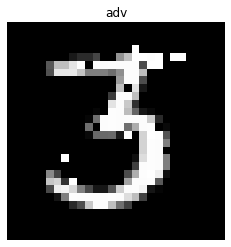

pred 5


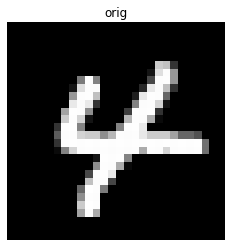

pred 4


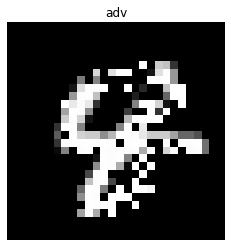

pred 8


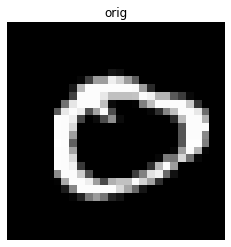

pred 0


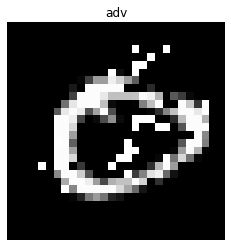

pred 6


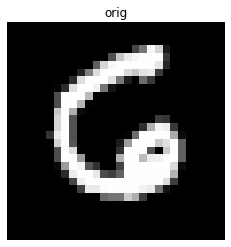

pred 6


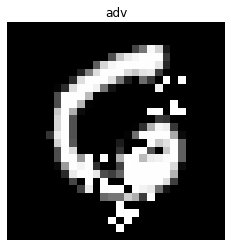

pred 9


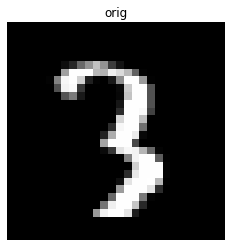

pred 3


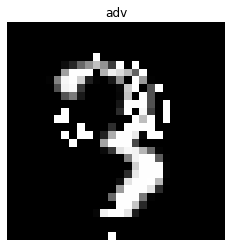

pred 9


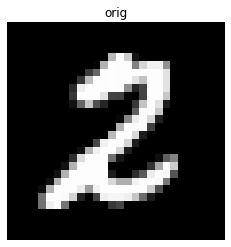

pred 2


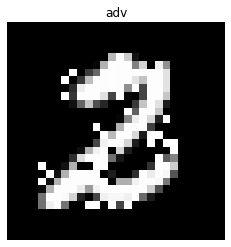

pred 3


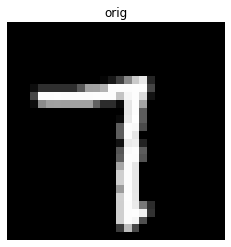

pred 7


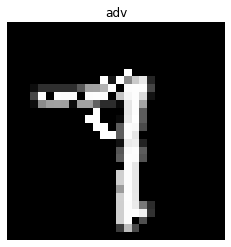

pred 9


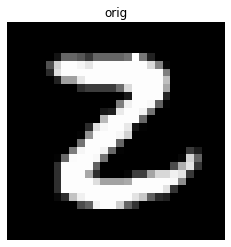

pred 2


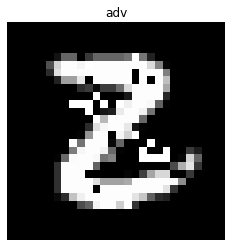

pred 8


In [44]:
# if adversarial_imgs[0] is not None:   # attack was successful
for i in range(20):
    
    plt.imshow(b[i, 0], cmap='gray')
    plt.title('orig')
    plt.axis('off')
    plt.show()
    print('pred', np.argmax(fmodel.predictions(b[i])))

    plt.imshow(adversarial_imgs[i,0], cmap='gray')
    plt.title('adv')
    plt.axis('off')
    plt.show()
    print('pred', np.argmax(fmodel.predictions(adversarial_imgs[i])))

In [54]:
cnt = 0

temp_adv = adversarial_imgs
for i in range(adversarial_imgs.shape[0]):
    if np.sum(adversarial_imgs[i]) != 0:
        cnt += 1
print(cnt)
print(np.sum(adversarial_imgs[128]))
print(np.sum(adversarial_imgs[129]))

21
0.0
0.0


score 0.0
pred 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


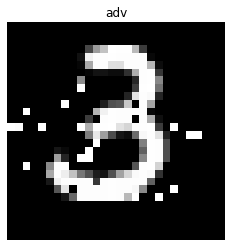

In [ ]:
pred_label = np.argmax(fmodel.batch_predictions(adversarial_imgs[:2800]), axis=1)
print('score', float(np.sum(pred_label == l)) / 2800)
print('pred', np.argmax(fmodel.predictions(adversarial_imgs[0])))
if adversarial_imgs[0] is not None:   # attack was successful
    plt.imshow(adversarial_imgs[0, 0], cmap='gray')
    plt.title('adv')
    plt.axis('off')
    plt.show()